In [1]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import scipy.stats as st
import random
from datetime import datetime

In [2]:
cur_dir = os.path.dirname('__file__')

train = pd.read_csv(os.path.join(cur_dir, "data", "train.csv"))
test = pd.read_csv(os.path.join(cur_dir, "data", "test.csv"))

In [3]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
def get_random_subset(df, n):
    sub = random.sample(xrange(len(df)), n)
    return df.iloc[sub]

def preprocess(df):
    res = df.copy()
    res.drop(df.index[660485], inplace=True)
    datetimes = res.Dates.apply(get_datetime)
    res['Hour'] = datetimes.apply(lambda dt: dt.hour)
    res['Month'] = datetimes.apply(lambda dt: dt.month)
    res['Hour_Minutes'] = datetimes.apply(lambda dt: dt.hour + dt.minute / 60.0)
    res['Minutes_Since_03'] = datetimes.apply(lambda dt: (dt-datetime(2003, 1, 1)).total_seconds() / 60)
    res['Minutes_Since_New_Year'] = datetimes.apply(lambda dt: (dt-datetime(dt.year, 1, 1)).total_seconds() / 60)
    return res

def get_datetime(s):
    dt = datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
    return dt

def get_random_subset(df, n):
    sub = random.sample(xrange(len(df)), n)
    return df.iloc[sub]

In [5]:
train = preprocess(train)

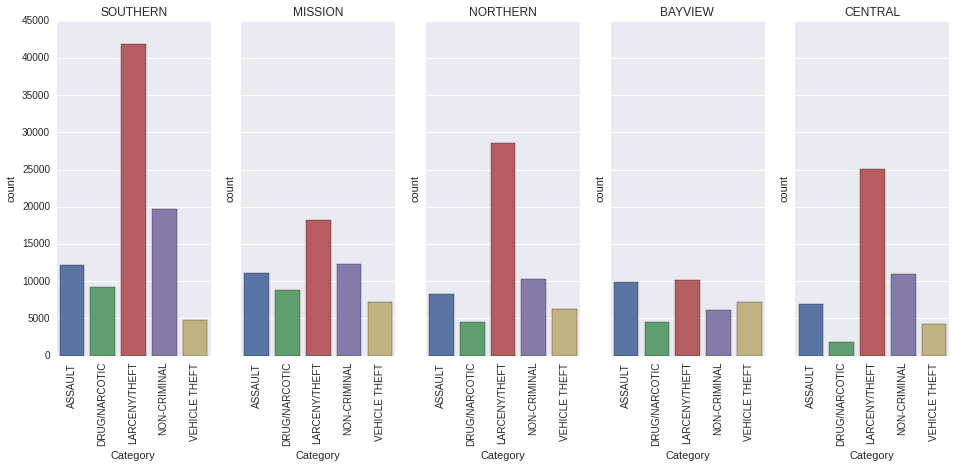

In [6]:
most_common_cats = train.Category[train.Category != "OTHER OFFENSES"].value_counts().index[0:5]
most_common_districts = train.PdDistrict.value_counts().index[0:5]


f, axtuple = plt.subplots(1, len(most_common_cats), sharey=True)

for i in range(len(most_common_districts)):
    
    subset = train[(train.PdDistrict == most_common_districts[i]) & train.Category.isin(most_common_cats)]
    
    ax = sns.countplot(x="Category", data=subset.sort_values("Category"), ax=axtuple[i])
    ax.set_title(most_common_districts[i])
    plt.sca(ax)
    plt.xticks(rotation=90)
    
plt.gcf().set_size_inches(16, 6, forward=True)


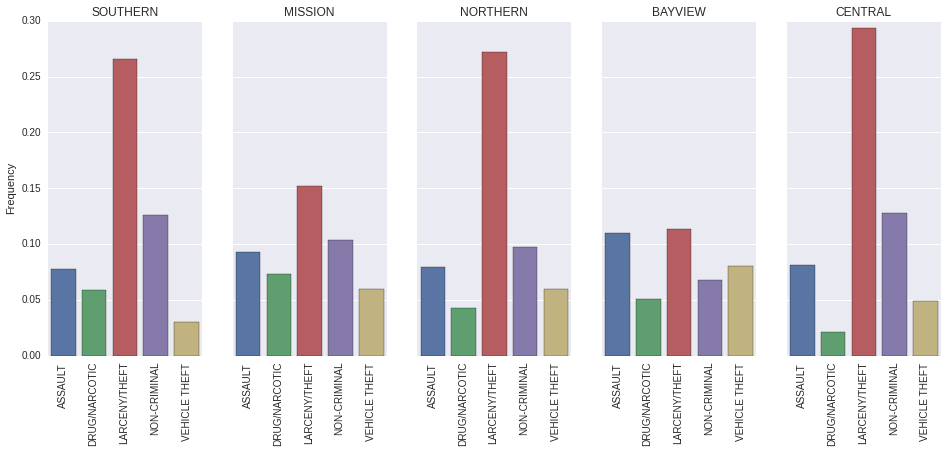

In [7]:
most_common_cats = train.Category[train.Category != "OTHER OFFENSES"].value_counts().index[0:5]
most_common_districts = train.PdDistrict.value_counts().index[0:5]


f, axtuple = plt.subplots(1, len(most_common_cats), sharey=True)


for i in range(len(most_common_districts)):
    
    subset = train[train.PdDistrict == most_common_districts[i]]
    proportions = (subset.Category.value_counts().astype(float) / len(subset)).loc[most_common_cats]
    proportions = proportions.sort_index()
    
    
    
    ax = sns.barplot(x=proportions.index, y=proportions, ax=axtuple[i])
    ax.set_title(most_common_districts[i])
    ax.set_ylabel("")
    plt.sca(ax)
    plt.xticks(rotation=90)
    
axtuple[0].set_ylabel("Frequency")
plt.gcf().set_size_inches(16, 6, forward=True)


/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/usr/local/lib/python2.7/dist-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/usr/local/lib/python2.7/dist-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


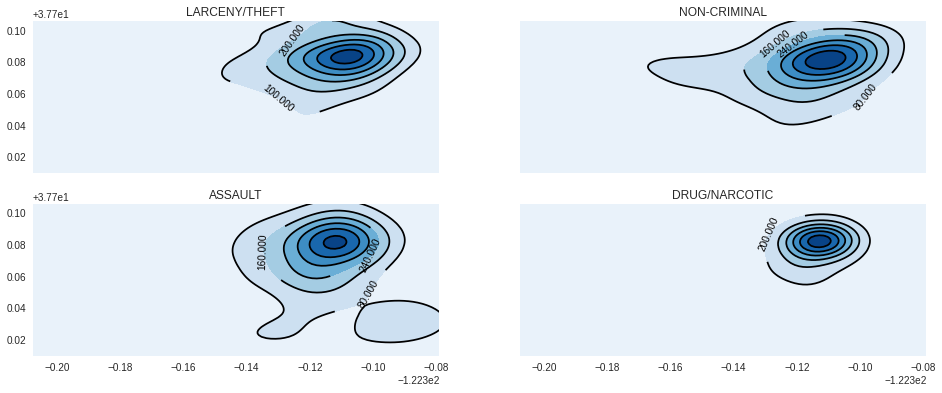

In [8]:
train_subset = get_random_subset(train, 5000)

cats = [['LARCENY/THEFT', 'NON-CRIMINAL'], ['ASSAULT', 'DRUG/NARCOTIC']]

f, axtuple = plt.subplots(2, 2, sharey=True, sharex=True)

rows, cols = axtuple.shape

for j in range(rows):
    
    for i in range(cols):

        subset = train_subset[train_subset.Category == cats[j][i]]

        x = subset.X
        y = subset.Y

        # plt.scatter(x, y)

        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()

        # # Peform the kernel density estimate
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])
        kernel = st.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)

    #     fig = plt.figure()
        ax = axtuple[j, i]
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_title(cats[j][i])
        cfset = ax.contourf(xx, yy, f, cmap='Blues')
        cset = ax.contour(xx, yy, f, colors='k')
        ax.clabel(cset, inline=1, fontsize=10)
    

plt.gcf().set_size_inches(16, 6, forward=True)
    
# axtuple[0].set_ylabel("Frequency")
# plt.gcf().set_size_inches(16, 6, forward=True)

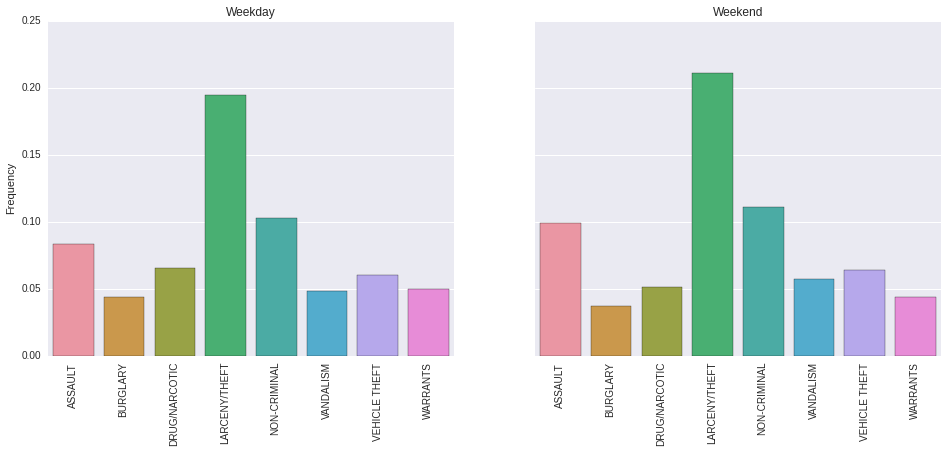

In [9]:
most_common_cats = train.Category[train.Category != "OTHER OFFENSES"].value_counts().index[0:8]
day_counts = train.DayOfWeek.value_counts().index[0:7]

def isWeekend(day):
    if day in ["Saturday", "Sunday"]:
        return "Weekend"
    else:
        return "Weekday"


train["Weekend"] = train["DayOfWeek"].apply(isWeekend)

day_type_counts = train.Weekend.value_counts().index

f, axtuple = plt.subplots(1, len(day_type_counts), sharey=True)


for i, day in enumerate(day_type_counts):
    
    subset = train[train.Weekend == day]
    proportions = (subset.Category.value_counts().astype(float) / len(subset)).loc[most_common_cats]
    proportions = proportions.sort_index()
    
    ax = sns.barplot(x=proportions.index, y=proportions, ax=axtuple[i])
    ax.set_title(day)
    ax.set_ylabel("")
    plt.sca(ax)
    plt.xticks(rotation=90)
    
axtuple[0].set_ylabel("Frequency")
plt.gcf().set_size_inches(16, 6, forward=True)

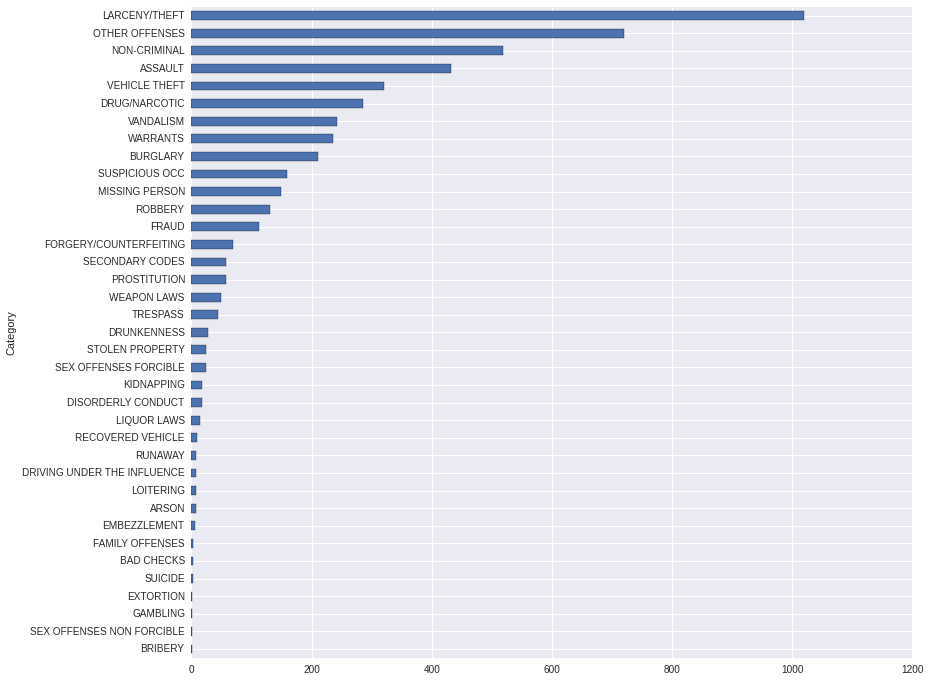

In [10]:
def plot_Category(df):
    cat_Count = df.groupby("Category").count()
    plt.figure()
    cat_Count.sort_values(by="Dates", ascending=1)["Dates"].plot(kind="barh")
    plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
    plt.tight_layout()
    plt.gcf().set_size_inches(16, 10, forward=True)
    
plot_Category(train_subset)

In [21]:
dow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# dow = {
#     'Monday':0,
#     'Tuesday':1,
#     'Wednesday':2,
#     'Thursday':3,
#     'Friday':4,
#     'Saturday':5,
#     'Sunday':6
# }
train['DOW'] = train.DayOfWeek.apply(lambda x: dow.index(x))

[0 1 2 3 4 5 6]


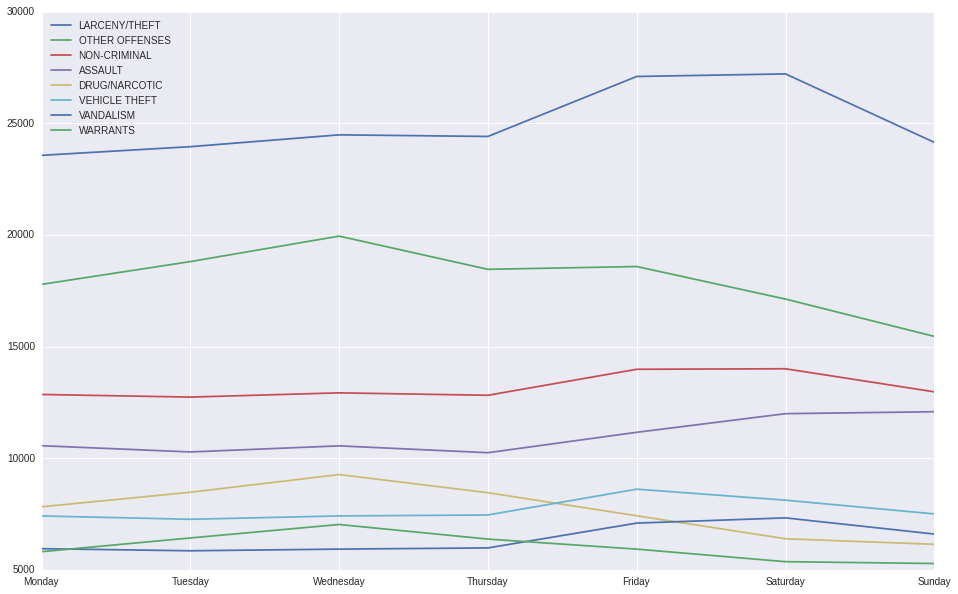

In [22]:

# train_subset = train_subset.dropna(subset=['DOW', 'Category'])
categories = train.Category.value_counts().index[0:8]
bins = np.arange(0,7, 1)
for c in categories:
    subset = train[train.Category == c]
    indices = np.digitize(subset.DOW, bins)
    groups = subset.groupby(indices)
    days = [g.DOW.mean() for _, g in groups]
    crimes = [len(g) for _, g in groups]
    plt.plot(days, crimes, label=c)
plt.legend(loc=2)
plt.gcf().set_size_inches(16, 10, forward=True)
plt.gca().set_xticklabels(dow)